# Chapter 11: Building A Generative Pre-Trained Transformer (GPT) from Scratch

This chapter covers

* How to build a generative pre-trained Transformer (GPT) from scratch
* How causal self-attention works
* How to extract model weights from a pre-trained model and load them to your own
* Generating coherent text using GPT-2, the predecessor of ChatGPT and GPT-4

Generative Pre-trained Transformer 2 (GPT-2) is an advanced large language model (LLM) developed by OpenAI and announced in February 2019. It represents a significant milestone in the field of natural language processing (NLP) and has paved the way for the development of even more sophisticated models, including its successors, ChatGPT and GPT-4. 

GPT-2 was introduced in 2018 as an improvement over its predecessor, GPT-1. GPT-2 was designed to generate coherent and contextually relevant text based on a given prompt, demonstrating a remarkable ability to mimic human-like text generation across various styles and topics. Upon its announcement, OpenAI initially decided not to release to the public the most powerful version of GPT-2 (also the one you’ll build from scratch in this chapter, with 1.5 billion parameters). The main concern was potential misuse, such as generating misleading news articles, impersonating individuals online, or automating the production of abusive or fake content. This decision sparked a significant debate within the AI and tech communities about the ethics of AI development and the balance between innovation and safety.

OpenAI later adopted a staggered release strategy, gradually making smaller versions of the model available while monitoring the impact and exploring safe deployment strategies. Eventually, in November 2019, OpenAI released the full model, along with several datasets and a tool to detect model-generated text, contributing to discussions on responsible AI usage. Because of this release, you’ll learn to extract the pre-trained weights from GPT-2 and load them to the GPT-2 model that you create.

GPT-2 is based on the Transformer architecture that we discussed in Chapters 9 and 10. However, unlike the English-to-French translator you created before, GPT-2 is a decoder-only Transformer, meaning there is no encoder stack in the model. When translating an English phrase into French, the encoder captures the meaning of the English phrase and passes it to the decoder to generate the translation. However, in text generation tasks, the model does not need an encoder to understand a different language. Instead, it generates text based on the previous tokens in the sentence.   Like other Transformer models, GPT-2 uses self-attention mechanisms to process input data in parallel, significantly improving the efficiency and effectiveness of training large language models. 

GPT-2 is pre-trained on a large corpus of text data, essentially predicting the next word in a sentence given the words that precede it. This training enables the model to learn a wide range of language patterns, grammar, and knowledge. 

In this chapter, you’ll learn to build GPT-2XL, the largest version of GPT-2, from scratch. After that, you’ll learn how to extract the pre-trained weights from Hugging Face (an AI community that hosts and collaborates on ML models, datasets, and applications) and load them to your own GPT-2 model. You’ll use your GPT-2 to generate text by feeding a prompt to the model. GPT-2 calculates the probabilities of possible next tokens and samples from these probabilities. It can produce coherent and contextually relevant paragraphs of text based on the input prompt it receives. Additionally, as you did in Chapter 8, you can control the creativeness of the generated text by using temperature and top-K sampling. 

While GPT-2 marks a notable advance in NLP, it's essential to moderate your expectations and recognize its inherent limitations. It's crucial not to compare GPT-2 with ChatGPT or GPT-4 directly, as GPT-2XL has only 1.5 billion parameters compared to ChatGPT's 175 billion and GPT-4's estimated 1.76 trillion parameters.  One of the main limitations of GPT-2 is its lack of genuine comprehension of the content it generates. The model predicts the next word in a sequence based on the probability distribution of words in its training data, which can produce syntactically correct and seemingly logical text. However, the model lacks a true understanding of the meaning behind the words, leading to potential inaccuracies, nonsensical statements, or superficial content.

Another key issue is GPT-2's limited contextual awareness. While it can maintain coherence over short spans of text, it struggles with longer passages, potentially resulting in a loss of coherence, contradictions, or irrelevant content. We should be cautious not to overestimate the model's ability to generate long-form content that requires sustained attention to context and detail. Therefore, while GPT-2 represents a significant step forward in NLP, it's important to approach its generated text with a healthy dose of skepticism and set realistic expectations. 

# 1.	GPT-2 Architecture and Causal Self-Attention
## 1.1.	The architecture of GPT-2
## 1.2.	Word embedding and positional encoding in GPT-2

## 1.3.	Causal Self-Attention in GPT-2

In [1]:
import torch
import torch.nn as nn

torch.manual_seed(42)
x=torch.randn((1,4,1600))
c_attn=nn.Linear(1600,1600*3)
B,T,C=x.size()
q,k,v=c_attn(x).split(1600,dim=2)
print(f"the shape of Q vector is {q.size()}")
print(f"the shape of K vector is {k.size()}")
print(f"the shape of V vector is {v.size()}")

the shape of Q vector is torch.Size([1, 4, 1600])
the shape of K vector is torch.Size([1, 4, 1600])
the shape of V vector is torch.Size([1, 4, 1600])


In [2]:
hs=C//25
k = k.view(B, T, 25, hs).transpose(1, 2) 
q = q.view(B, T, 25, hs).transpose(1, 2) 
v = v.view(B, T, 25, hs).transpose(1, 2) 
print(f"the shape of Q vector is {q.size()}")
print(f"the shape of K vector is {k.size()}")
print(f"the shape of V vector is {v.size()}")

the shape of Q vector is torch.Size([1, 25, 4, 64])
the shape of K vector is torch.Size([1, 25, 4, 64])
the shape of V vector is torch.Size([1, 25, 4, 64])


In [3]:
import math
scaled_att = (q @ k.transpose(-2, -1)) *\
            (1.0 / math.sqrt(k.size(-1)))
print(scaled_att[0,0]) 

tensor([[ 0.2334,  0.1385, -0.1305,  0.2664],
        [ 0.2916,  0.1044,  0.0095,  0.0993],
        [ 0.8250,  0.2454,  0.0214,  0.8667],
        [-0.1557,  0.2034,  0.2172, -0.2740]], grad_fn=<SelectBackward0>)


In [4]:
# answer to exercise 11.1
# print out the scaled attention scores in the second head
print(scaled_att[0,1]) 

tensor([[-0.1720, -0.2462, -0.5019,  0.1796],
        [-0.1566,  0.3681, -0.2610,  0.1355],
        [ 0.4394, -0.5173, -0.1076, -0.3687],
        [-0.0101,  0.6201,  0.3146, -0.0139]], grad_fn=<SelectBackward0>)


In [5]:
mask=torch.tril(torch.ones(4,4))
print(mask)
masked_scaled_att=scaled_att.masked_fill(\
    mask == 0, float('-inf'))
print(masked_scaled_att[0,0]) 

tensor([[1., 0., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 1.]])
tensor([[ 0.2334,    -inf,    -inf,    -inf],
        [ 0.2916,  0.1044,    -inf,    -inf],
        [ 0.8250,  0.2454,  0.0214,    -inf],
        [-0.1557,  0.2034,  0.2172, -0.2740]], grad_fn=<SelectBackward0>)


In [6]:
import torch.nn.functional as F
att = F.softmax(masked_scaled_att, dim=-1)
print(att[0,0])

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.5467, 0.4533, 0.0000, 0.0000],
        [0.4980, 0.2790, 0.2230, 0.0000],
        [0.2095, 0.3001, 0.3042, 0.1862]], grad_fn=<SelectBackward0>)


In [7]:
# answer to exercise 11.2
# print out the attention weights in the last head
print(att[0,-1]) 

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.4055, 0.5945, 0.0000, 0.0000],
        [0.3726, 0.3248, 0.3026, 0.0000],
        [0.2666, 0.1902, 0.3133, 0.2298]], grad_fn=<SelectBackward0>)


In [8]:
y=att@v
y = y.transpose(1, 2).contiguous().view(B, T, C)
print(y.shape)

torch.Size([1, 4, 1600])


# 2.	Build GPT-2XL from scratch

## 2.1. 	Byte pair encoder (BPE) tokenization

In [9]:
from utils.bpe import get_encoder

example="This is the original text."
bpe_encoder=get_encoder()
response=bpe_encoder.encode_and_show_work(example)
print(response["tokens"])

['This', ' is', ' the', ' original', ' text', '.']


In [10]:
print(response['bpe_idx'])

[1212, 318, 262, 2656, 2420, 13]


In [11]:
from utils.bpe import BPETokenizer 

tokenizer = BPETokenizer()
out=tokenizer.decode(torch.LongTensor(response['bpe_idx']))   
print(out)

This is the original text.


In [12]:
# answer to exercise 11.3
# split the phrase "this is a prompt" into tokens
example="this is a prompt"
bpe_encoder=get_encoder()
response=bpe_encoder.encode_and_show_work(example)
print(response["tokens"])
# After that, map the tokens to indexes
print(response['bpe_idx'])
# Finally, restore the phrase based on the indexes 
out=tokenizer.decode(torch.LongTensor(response['bpe_idx']))   
print(out)

['this', ' is', ' a', ' prompt']
[5661, 318, 257, 6152]
this is a prompt


## 2.2.	The GELU activation function

In [13]:
class GELU(nn.Module):
    def forward(self, x):
        return 0.5*x*(1.0+torch.tanh(math.sqrt(2.0/math.pi)*\
                       (x + 0.044715 * torch.pow(x, 3.0))))

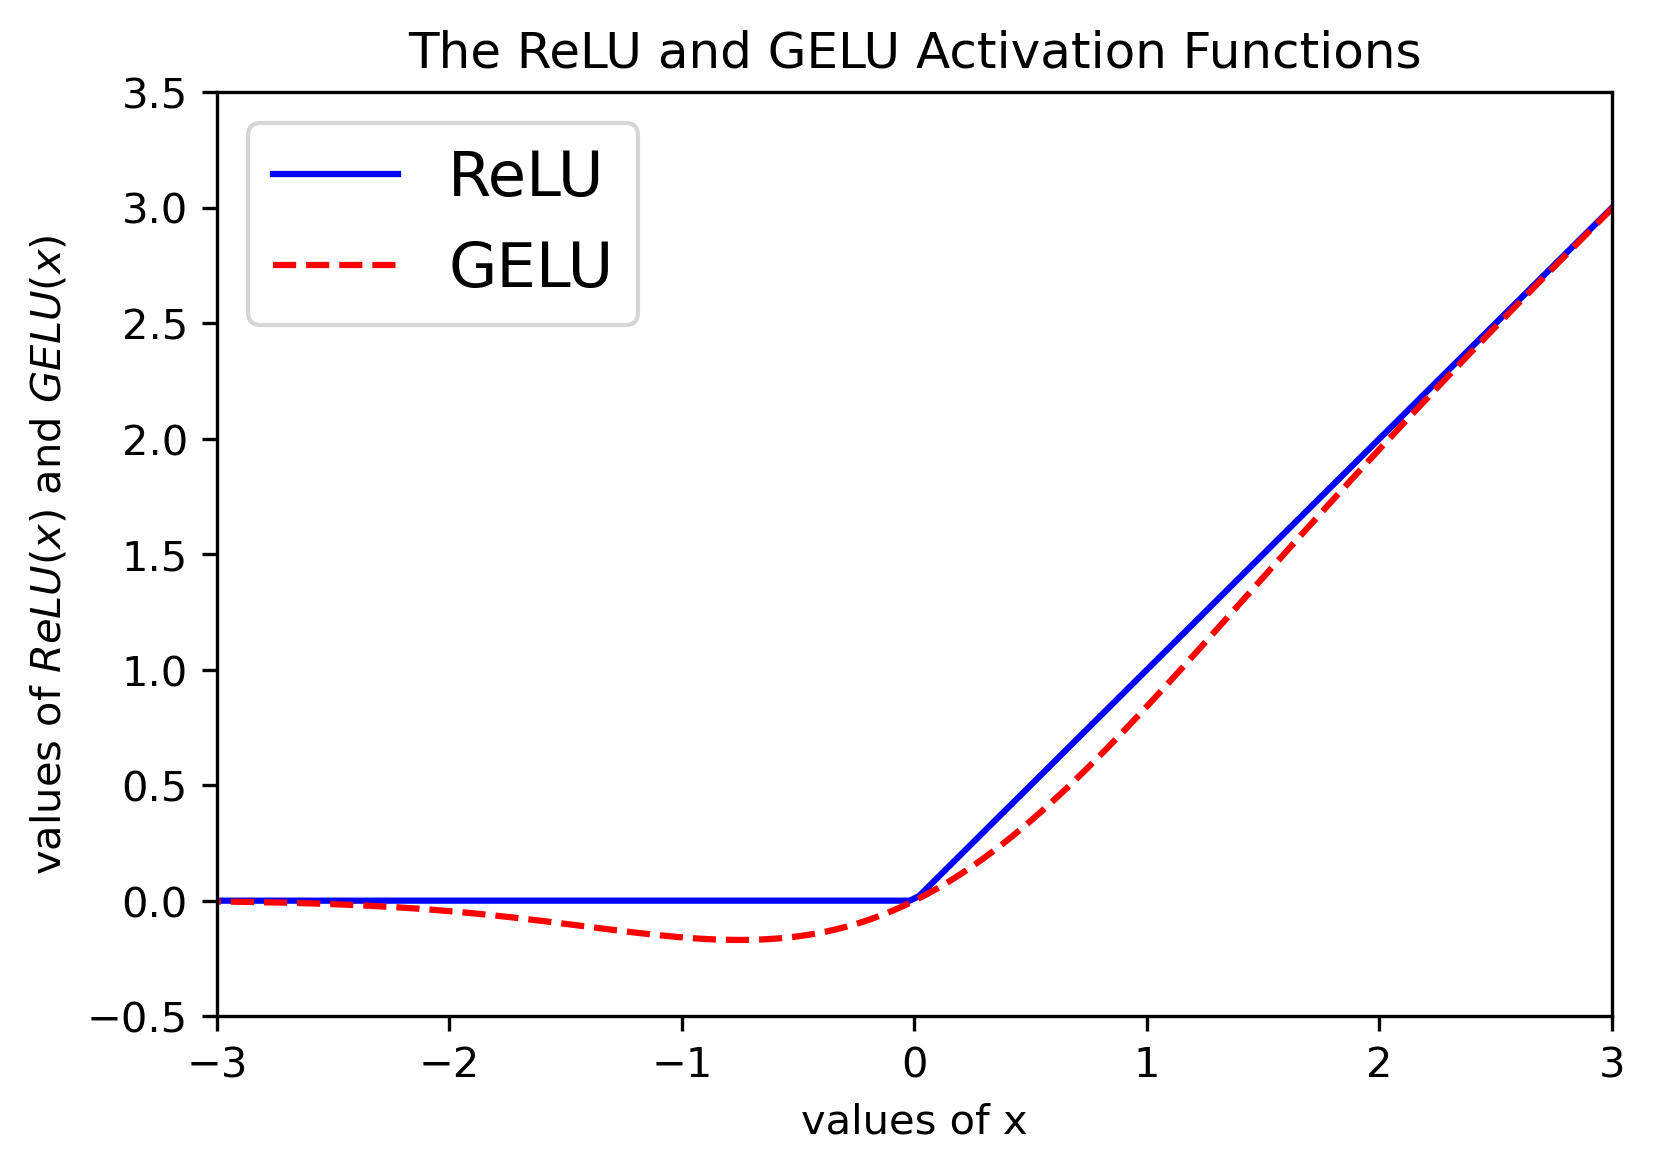

In [14]:
import matplotlib.pyplot as plt
import numpy as np

genu=GELU()
def relu(x):
    y=torch.zeros(len(x))
    for i in range(len(x)):
        if x[i]>0:
            y[i]=x[i]
    return y                 
xs = torch.linspace(-6,6,300)
ys=relu(xs)
gs=genu(xs)
fig, ax = plt.subplots(figsize=(6,4),dpi=300)
plt.xlim(-3,3)
plt.ylim(-0.5,3.5)
plt.plot(xs, ys, color = 'blue', label="ReLU")
plt.plot(xs, gs, "--", color = 'red', label="GELU")
plt.legend(fontsize=15)
plt.xlabel("values of x")
plt.ylabel("values of $ReLU(x)$ and $GELU(x)$")
plt.title("The ReLU and GELU Activation Functions")
plt.show()

## 2.3.	Causal self-attention

In [ ]:
# define hyperparameters
class Config():
    def __init__(self):
        self.n_layer = 48
        self.n_head = 25
        self.n_embd = 1600
        self.vocab_size = 50257
        self.block_size = 1024 
        self.embd_pdrop = 0.1 
        self.resid_pdrop = 0.1 
        self.attn_pdrop = 0.1 
        
# instantiate a Config() class
config=Config()

In [16]:
class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.attn_dropout = nn.Dropout(config.attn_pdrop)
        self.resid_dropout = nn.Dropout(config.resid_pdrop)
        self.register_buffer("bias", torch.tril(torch.ones(\
                   config.block_size, config.block_size))
             .view(1, 1, config.block_size, config.block_size))
        self.n_head = config.n_head
        self.n_embd = config.n_embd

    def forward(self, x):
        B, T, C = x.size() 
        q, k ,v  = self.c_attn(x).split(self.n_embd, dim=2)
        hs = C // self.n_head
        k = k.view(B, T, self.n_head, hs).transpose(1, 2) 
        q = q.view(B, T, self.n_head, hs).transpose(1, 2) 
        v = v.view(B, T, self.n_head, hs).transpose(1, 2) 

        att = (q @ k.transpose(-2, -1)) *\
            (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, \
                              float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        y = att @ v 
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))
        return y

## 2.4.	Construct the GPT-2XL model

In [17]:
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = nn.ModuleDict(dict(
            c_fc   = nn.Linear(config.n_embd, 4 * config.n_embd),
            c_proj = nn.Linear(4 * config.n_embd, config.n_embd),
            act    = GELU(),
            dropout = nn.Dropout(config.resid_pdrop),
        ))
        m = self.mlp
        self.mlpf=lambda x:m.dropout(m.c_proj(m.act(m.c_fc(x)))) 

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlpf(self.ln_2(x))
        return x

In [18]:
class GPT2XL(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.block_size = config.block_size
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.embd_pdrop),
            h = nn.ModuleList([Block(config) 
                               for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),))
        self.lm_head = nn.Linear(config.n_embd,
                                 config.vocab_size, bias=False)      
    def forward(self, idx, targets=None):
        b, t = idx.size()
        pos = torch.arange(0,t,dtype=torch.long).unsqueeze(0)
        tok_emb = self.transformer.wte(idx) 
        pos_emb = self.transformer.wpe(pos) 
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x)
        loss = None
        if targets is not None:
            loss=F.cross_entropy(logits.view(-1,logits.size(-1)),
                           targets.view(-1), ignore_index=-1)
        return logits, loss

In [19]:
model=GPT2XL(config)
num=sum(p.numel() for p in model.transformer.parameters())
print("number of parameters: %.2fM" % (num/1e6,))

number of parameters: 1557.61M


In [20]:
print(model)

GPT2XL(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 1600)
    (wpe): Embedding(1024, 1600)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-47): 48 x Block(
        (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=1600, out_features=4800, bias=True)
          (c_proj): Linear(in_features=1600, out_features=1600, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (mlp): ModuleDict(
          (c_fc): Linear(in_features=1600, out_features=6400, bias=True)
          (c_proj): Linear(in_features=6400, out_features=1600, bias=True)
          (act): GELU()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head

# 3.	Load up pre-trained weights and generate text
## 3.1. 	Load up pre-trained parameters in GPT-2XL

In [21]:
# install the transformers library developed by Hugging Face
!pip install transformers

In [22]:
from transformers import GPT2LMHeadModel

model_hf = GPT2LMHeadModel.from_pretrained('gpt2-xl')
sd_hf = model_hf.state_dict()  
print(model_hf)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1600)
    (wpe): Embedding(1024, 1600)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-47): 48 x GPT2Block(
        (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=4800, nx=1600)
          (c_proj): Conv1D(nf=1600, nx=1600)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=6400, nx=1600)
          (c_proj): Conv1D(nf=1600, nx=6400)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1600, out_features=50257, bias=False)
)


In [23]:
print(model_hf.transformer.h[0].mlp.c_fc.weight.shape) 

torch.Size([1600, 6400])


In [24]:
print(model.transformer.h[0].mlp.c_fc.weight.shape)

torch.Size([6400, 1600])


In [25]:
keys = [k for k in sd_hf if not k.endswith('attn.masked_bias')] 

We'll also extract the state dictionary for the GPT2 model we just created ourselves:

In [26]:
sd=model.state_dict()

In [27]:
transposed = ['attn.c_attn.weight', 'attn.c_proj.weight',
              'mlp.c_fc.weight', 'mlp.c_proj.weight']
for k in keys:
    if any(k.endswith(w) for w in transposed):
        # special treatment for Conv1D weights
        with torch.no_grad():
            sd[k].copy_(sd_hf[k].t())
    else:
        with torch.no_grad():
            sd[k].copy_(sd_hf[k])

## 3.2. 	Define a generate() function to produce text

In [ ]:
model.eval()
def sample(idx, max_new_tokens, temperature=1.0, top_k=None):
    for _ in range(max_new_tokens):
        # if the text is more than 1024 tokens, trim it
        if idx.size(1) <= config.block_size:
            idx_cond = idx  
        else:
            idx_cond = idx[:, -config.block_size:]
        # predict the logits for the index in sequence
        logits, _ = model(idx_cond)
        # pluck the logits at the final step; apply temperature 
        logits = logits[:, -1, :] / temperature
        # optionally crop the logits to only the top k options
        if top_k is not None:
            v, _ = torch.topk(logits, top_k)
            logits[logits < v[:, [-1]]] = -float('Inf')
        # apply softmax to get probabilities
        probs = F.softmax(logits, dim=-1)
        idx_next = torch.multinomial(probs, num_samples=1)
        if idx_next.item()==tokenizer.encoder.encoder['<|endoftext|>']:
            break
        # append new index to sequence 
        idx = torch.cat((idx, idx_next), dim=1)
    return idx 

In [29]:
def generate(prompt, max_new_tokens, temperature=1.0,
             top_k=None):
    if prompt == '':
        x=torch.tensor([[tokenizer.encoder.encoder['<|endoftext|>']]],
                         dtype=torch.long)
    else:
        x = tokenizer(prompt)
    y = sample(x, max_new_tokens, temperature, top_k)
    out = tokenizer.decode(y.squeeze())
    print(out)

In [30]:
prompt=""
torch.manual_seed(42)
generate(prompt, max_new_tokens=100, temperature=1.0,
             top_k=None)

<|endoftext|>Surely the work is done in Canada. If someone is translating Laato's In the Publishing House it's for us. I'm surprised ACM hasn't picked it up yet.


In other news, I noticed this smattering of material after being all giddy about In the Biz.


In [31]:
# answer to exercie 11.4
prompt=""
torch.manual_seed(42)
generate(prompt, max_new_tokens=100, temperature=0.9,
             top_k=40)  

<|endoftext|>I've been in the hospital since my cat was discovered in a tree in downtown L.A. back in the spring. Since then, I've had a slew of procedures, multiple tests, and a full recovery. The first thing to address is the cat that was discovered in a tree, since it's become such a part of my life and the memories I share with both my wife and our son.

I first met Lace when I saw her one day and was struck by how


In [32]:
prompt="I went to the kitchen and"
for i in range(5):
    torch.manual_seed(i)
    generate(prompt, max_new_tokens=10, temperature=1.0,
                 top_k=None)

I went to the kitchen and said, you're not going to believe this.
I went to the kitchen and noticed a female producer open a drawer in which was
I went to the kitchen and asked who was going to be right there and A
I went to the kitchen and took a small vial of bourbon and a little
I went to the kitchen and found the bottle of wine, and poured it into


In [33]:
prompt="Lexington is the second largest city in the state of Kentucky"
torch.manual_seed(42)
generate(prompt, max_new_tokens=100, temperature=1.0,
             top_k=None)

Lexington is the second largest city in the state of Kentucky. It caters to those who want to make everything in tune with being with friends and enjoying a jaunt through the down to Earth lifestyle. To do so, they are blessed with several venues large and small to fill their every need while residing micro- cozy with nature within the landmarks of the city.

In a moment we look at ten up and coming suchache music acts from the Lexington area to draw upon your attention.

Lyrikhop


This Lexington-based group


In [34]:

prompt="Lexington is the second largest city in the state of Kentucky"
torch.manual_seed(42)
generate(prompt, max_new_tokens=100, temperature=0.9,
             top_k=50)

Lexington is the second largest city in the state of Kentucky. It is also the state capital. The population of Lexington was 1,731,947 in the 2011 Census. The city is well-known for its many parks, including Arboretum, Zoo, Aquarium and the Kentucky Science Center, as well as its restaurants, such as the famous Kentucky Derby Festival.

In the United States, there are at least 28 counties in this state with a population of more than 100,000, according to the 2010 census.




In [35]:
# answer to exercise 11.5
torch.manual_seed(42)
generate(prompt, max_new_tokens=100, temperature=1.2,
             top_k=None)   

Lexington is the second largest city in the state of Kentucky but only one-third that size. Only about 50,000 people live there, less than a fifth the density spread down to the Jay River facility. Jefferson Central Bombshells Civil Arson argument lives by Henry Nash Clark Them metro-dwellers could not remove Paul Hinze from his campus residence.

On Sunday morning, two local upstarts such as Mr. Palestarelli and Mr Cassadaga might just have settled the demolition nation eystem with little more than quiet negotiations
